# Análisis de riesgos/beneficios de posibles locaciones para el desarrollo de nuevos pozos petroleros

El objetivo de este trabajo es ayudar a determinar la región geográfica más óptima para el desarrollo de 200 nuevos pozos petroleros de la compañía Oily Giant, a través del cálculo de ganancias potenciales y el riesgo de pérdidas económicas.

Para lograr este objetivo se crea un modelo de aprendizaje supervisado que predice el volumen de reservas de crudo a partir de parámetros indicadores de calidad. Posteriormente se calcula la raíz del error cuadrático medio para evaluar la calidad de este modelo implementado en las tres regiones de estudio. 

Después se diseña una función para calcular las ganancias proyectadas para los 200 pozos con mayores reservas estimadas en cada una de las tres regiones. Posteriormente se utiliza el método de bootstrap para 1000 submuestras de 500 pozos para calcular la ganancia promedio total y su intervalo de confianza de 95% para cada región. Además se calcula el riesgo de pérdidas expresado como probabilidad.

Finalmente se encuentra la región con mayor potencial de ganancias y menos riesgo de pérdidas.

Para este análisis se consideran los siguientes puntos:

· Al explorar la región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.

· El presupuesto es de 100 millones de dólares.

· Un barril de materias primas genera 4.5 USD de ingresos. 

· Se mantienen solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se selecciona la región con el beneficio promedio más alto.

## Importación de paquetes y librerías

Se emplean principalmente herramientas de las librerías pandas y sklearn. Adicionalmente se emplea matplotlib para la realización de gráficos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Inspección inicial de datos

A continuación se importan las tres bases de datos correspondientes a las tres regiones geográficas exploradas.

In [2]:
region_0 = pd.read_csv('/datasets/geo_data_0.csv')
region_1 = pd.read_csv('/datasets/geo_data_1.csv')
region_2 = pd.read_csv('/datasets/geo_data_2.csv')

Se muestra la información de cada una.

In [3]:
datasets = [region_0, region_1, region_2]

for dataset in datasets:
    print(dataset.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

Cada dataset contiene 100,000 entradas, con cinco columnas correspondientes a:

 · *id* identificador del pozo petrolero
 
 · *f0, f1, f2* indicadores de calidad del crudo
 
 · *product* volumen de la reserva en miles de barriles

No se encuentran valores ausentes en ninguna de las bases de datos, los tipos de datos son apropiados para cada columna.

Se prosige a mostrar el encabezado de cada base de datos.

In [4]:
for count, dataset in enumerate(datasets):
    print(f'Region {count}')
    display(dataset.head())
    print()

Region 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Region 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Region 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


No se encuentran incongruencias aparentes en las bases de datos. 
Se procede a detactar datos duplicados:

In [5]:
for count, dataset in enumerate(datasets):
    print(f'Región {count} tiene {dataset.duplicated().sum()} filas duplicadas')

Región 0 tiene 0 filas duplicadas
Región 1 tiene 0 filas duplicadas
Región 2 tiene 0 filas duplicadas


Ninguna base de datos presenta filas completamente duplicadas. Se procede a mostrar la descripción de cada base de datos.

In [6]:
for count, dataset in enumerate(datasets):
    
    print(f'Región {count}')
    display(dataset.describe())
    print()

Región 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Región 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Región 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Se observa que los valores de las columnas f0, f1, y f2 pueden ser negativos y llegar hasta unas cuantas decenas. El volumen de crudo tiene valores positivos y razonables, se observa que hay locaciones con reservas nulas y la locación con mayores reservas alcanza los 190 miles de barriles. También se observa que la desviación estándar del volumen de reserva es muy similar en los tres conjuntos de datos.

En promedio la región 2 tiene más reservas de petróleo, seguida de la región 0 y la región 1.

La inspección inicial no presenta valores ausentes, duplicados o incongruentes. Los tipos de dato y el formato son adecuados, por lo cual se procede al desarrollo del modelo.

## Modelo Predictivo para Volumen de Reservas de Crudo

En esta sección se desarrolla un modelo de aprendizaje supervisado mediante regresión lineal con el objetivo de  predecir el volumen de reservas de crudo para pozos futuros. Para evaluar la calidad del modelo aplicado en cada una de las tres regiones se calcula la Raíz del Error Cuadrático Medio (RMSE por sus siglas en inglés).

Se desarrollan tres funciones para automatizar el proceso para las etapas de preparación de datos, entrenamiento-predicción y evaluación de resultados para evaluar el modelo.

### Preparación de datos

En primer lugar se define el objetivo como el volumen de reservas 'products', y las características como las columnas 'f0', 'f1' y 'f2'. 

Posteriormente se segmenta el conjunto de datos en subconjuntos de entrenamiento (75%) y validación (25%).

In [7]:
def preprocess(dataset):
    '''Define los objetivos y características y
    realiza la segmentación'''
    
    target = dataset['product'] #objetivo
    features = dataset[['f0', 'f1', 'f2']] #características
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    return features_train, features_valid, target_train, target_valid

### Entrenamiento y predicciones

Se utiliza Regresión Lineal para entrenar el modelo y se calculan las predicciones.

In [8]:
def train_and_predict(features_train, features_valid, target_train):
    
    #entrenamiento del modelo de regresión lineal
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    #predicciones
    predicted_valid = model.predict(features_valid)

    return predicted_valid

### Resumen y evaluación del modelo

La siguiente función calcula el promedio de las predicciones, el error cuadrático medio y la raíz del error cuadrátivo medio.

In [9]:
def mean_and_rmse(predicted_valid, target_valid):
            
    predicted_mean = predicted_valid.mean() #promedio de las predicciones
    
    mse = mean_squared_error(target_valid, predicted_valid) #error cuadrático medio
    
    rmse = mse**(1/2) #raíz del error cuadrático medio
    
    return predicted_mean, rmse

### Volumen Estimado por Regiones.

En esta subsección se implementan las funciones definidas anteriormente a cada una de las tres regiones.

Para cada region se realiza la segmentación, entrenamiento y predicciones. Los objetivos y las predicciones del conjunto de validación se almacenan en 'targets' y 'predictions'.

In [10]:
#datasets vacío para almacenar las predicciones y objetivos
predictions_and_targets=pd.DataFrame()

#dataset para almacenar el promedio de las predicciones y el rmse
summary= pd.DataFrame(columns=['Mean Predicted Volume', 'RMSE'], index=['Region 0', 'Region 1', 'Region 2']) 

for count, dataset in enumerate(datasets):
    
    #segmentación
    features_train, features_valid, target_train, target_valid = preprocess(dataset)
     
    #entrenamiento y predicciones
    predicted_valid = train_and_predict(features_train, features_valid, target_train) 

    #cálculo de métricas
    predicted_mean, rmse = mean_and_rmse(predicted_valid, target_valid)
    
    predictions_and_targets['target'+str(count)]= target_valid #almacena los objetivos del conjunto de validación
    predictions_and_targets['prediction'+str(count)]= predicted_valid #almacena las predicciones

    #almaccena la media y el rmse
    summary.iloc[count][0] = predicted_mean
    summary.iloc[count][1] = rmse

In [11]:
summary

,Mean Predicted Volume,RMSE
Region 0,92.5926,37.5794
Region 1,68.7285,0.893099
Region 2,94.965,40.0297


Estos resultados son consistentes con los valores promedio calculados la sección de visualización inicial. Los volumenes estimados promedio de las regiones 1 y 2 son mayores al volumen estimado promedio de la región 1. Sin embargo el error cuadrático medio de estas regiones también es mucho mayor, lo cual indica menor certeza en las predicciones del modelo para estas regiones. 


Dado que el presupuesto para el desarrollo de 200 pozos nuevos es de 100 millones de dólares, cada pozo en promedio requiere una inversión de 500, 000 dólares. Por lo tanto se requiere que en promedio cada pozo genere un ingreso mayor a esta cantidad. 

Considerando que cada unidad de volumen genera 4,500 dólares en ingresos, en promedio cada pozo debe producir más de 111.111 unidades de volumen para generar ganancias.

In [12]:
total_budget= 100000000 #presupuesto total en dólares

income_per_unit = 4500 #ingreso por 1000 barriles en dólares

locations= 200 #número de pozos

minimum_volume = (total_budget / locations ) / income_per_unit

print(minimum_volume)

111.11111111111111


Los volumenes estimados promedio para las tres regiones son menores al volumen mínimo que debe producir un pozo para generar ganancias (111.1 unidades). Por lo cual se deberán elegir locaciones que superen este promedio.

Esto se puede observar en las siguientes gráficas.

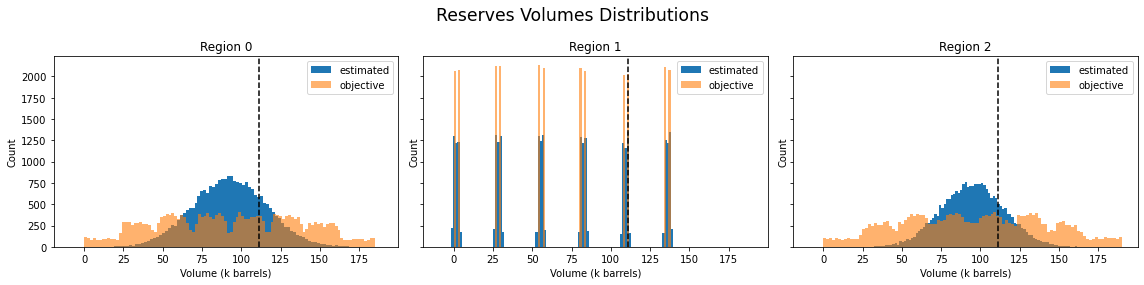

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,sharex=True, sharey=True, tight_layout=True, figsize=(16,4))

fig.suptitle('Reserves Volumes Distributions', fontsize='xx-large')

n_bins=100

for count, ax in enumerate(fig.get_axes()):
    
    #histogramas
    ax.hist(predictions_and_targets['prediction'+str(count)], bins=n_bins, label='estimated')
    ax.hist(predictions_and_targets['target'+str(count)], bins=n_bins, alpha=0.6, label='objective')
    
    #muestra el valor mínimo de volumen para generar ganancias
    ax.axvline(x=minimum_volume, color='k', linestyle='--')
    
    #nombres de ejes y leyendas
    ax.set_title(f'Region {count}')
    ax.set_xlabel('Volume (k barrels)')
    ax.set_ylabel('Count')
    ax.legend()

Gráficas de distribuciones de volumen de reservas (estimado en azul y objetivo en  naranja) para cada región. La línea negra punteada muestra el valor mínimo de volumen a partir del cual un pozo genera ganancias.

Lo primero que se puede observar es la diferencia notable entre las distribuciones de las regiones 0 y 2 en comparación con la región 1. Aunque todas las disribuciones objetivo son multimodales, en la región 1 los valores de volumen se centran alrededor de valores muy específicos con muy poca dispersión en cada uno. Por otro lado las distribuciones objetivo de las regiones 0 y 2, presentan mayor dispersión. Esta característica puede explicar por qué el RMSE para la región 1 es menor en comparación con las otras dos.

Además las formas de estas distribuciones nos indican la importancia de usar el método de bootstrapping para realizar inferencias estadísticas sobre el volumen objetivo.

Por otro lado se puede observar que el volumen mínimo para generar ganancia (111.1 miles de barriles) se encuentra arriba de la media de volumen para todas las regiones.

Las regiones 0 y 2 ofrecen la ventaja de tener mayores reservas promedio, sin embargo este beneficio se ve minimizado por la baja certeza del modelo para estas regiones. Por lo tanto es imprescindible hacer un análisis riesgo-beneficio más riguroso. Esto se encuentra en las siguientes secciones.

El volumen de reservas totales para cada región se puede considerar como el área bajo la curva de distribución a partir de cierto rango. 

## Proyección de ganancias

Se planean desarrollar 200 pozos petroleros en alguna de las tres regiones. A continuación se desarrolla una función para calcular la ganancia total de los 200 pozos con mayor volumen estimado, para cada región. Para lo cual, primero se ordenan las predicciones y se toman los 200 datos con mayores volumenes estimados. Posteriormente se identifican los volumenes objetivo correspondientes a estos pozos.

Para calcular el ingreso por región se multiplica el volumen total objetivo por el precio por unidad. Para calcular la ganancia se resta el presupuesto total del ingreso. Esto se repite para cada región.

In [14]:
def objective_profit(data):
    '''Calcula la ganancia total objetivo de los 200 pozos con mayores volumenes estimados
    para cada region.'''
    
    profits_per_region = []
    
    for count in range(3):
                
        #ordena las predicciones de forma descendiente y toma las primeras 200
        top_predictions = data['prediction'+str(count)].sort_values(ascending=False).head(200)
                
        #encuentra el volumen objetivo de las predicciones
        target_vol = data.loc[top_predictions.index]['target'+str(count)]
        
        #calcula el ingreso por volumen
        objective_incomes = target_vol*income_per_unit

        #calcula el ingreso total
        total_income = objective_incomes.sum()

        #calcula la ganancia restando el presupuesto total al ingreso total
        profit = round(total_income - total_budget,0)
        
        profits_per_region.append(profit)
        
    return profits_per_region

## Análisis de riesgos 

Para el análisis de riesgos se realiza el méodo de bootstrapping con reemplazo para seleccionar 1000 submuestras del conjunto de datos de validación. Posteriormente se calcula la proyección de ganancias para cada región con la ayuda de la función anterior.

Se consideran submuestras con 500 pozos.

In [15]:
state = np.random.RandomState(12345)

profits = pd.DataFrame(columns=['Region 0', 'Region 1', 'Region 2'])

for i in range(1000):
    #se toma una muestra de 500 pozos
    results_subsample =  predictions_and_targets.sample(n=500, replace=True, random_state=state)
    
    profits.loc[len(profits)] = objective_profit(results_subsample)

Una vez realizado el cálculo de ganacias potenciales para las tres regiones se procede a calcular el promedio de ganancias, el intervalo de confianza de 95%,  y el riesgo de pérdidas para cada región. 

Para el cálculo de riesgo se obtiene el porcentaje de submuestras que tuvieron ganancias menores o iguales a cero.

In [16]:
df = pd.DataFrame(columns=['Mean Proyected Profit (M usd dollars)', 'Lower', 'Upper', 'Risk of Loss (%)'],
                  index=['Region 0', 'Region 1', 'Region 2'])

for column in profits.columns:
    data= profits[column]
    
    #se calcula la ganancia promedio y se guarda
    mean = data.mean()
    df.loc[column][0] = mean 
    
    #se calcula el intervalo de confianza y se guarda
    lower = data.quantile(0.025)
    upper = data.quantile(0.975)
    
    df.loc[column][1] = lower
    df.loc[column][2] = upper
    
    #se calcula el riesgo y se guarda
    risk= len(data[data.le(0)]) / len(data) *100
    df.loc[column][3] = risk
    
df

,Mean Proyected Profit (M usd dollars),Lower,Upper,Risk of Loss (%)
Region 0,6.00735e+06,129483,1.23116e+07,2
Region 1,6.65241e+06,1.57989e+06,1.19764e+07,0.3
Region 2,6.1556e+06,-122185,1.23064e+07,3


La región 1 muestra el mayores ganancias promedio y menor riesgo de pérdidas, por lo tanto se sugiere invertir ahí. Esto también se puede visualizar en las siguientes gráficas.

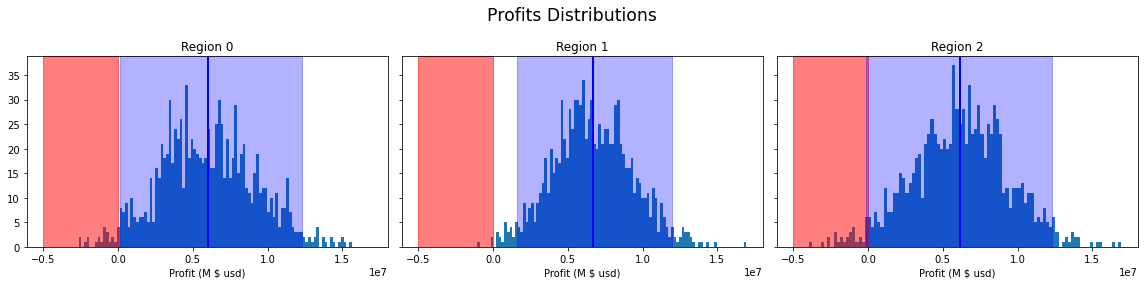

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,sharex=True, sharey=True, tight_layout=True, figsize=(16,4))

fig.suptitle('Profits Distributions', fontsize='xx-large')

n_bins=100

for count, ax in enumerate(fig.get_axes()):
    
    #histogramas
    ax.hist(profits.iloc[:,count], bins=n_bins)
    
    #muestra la zona de pérdidas e intervalo de confianza
    ax.axvspan(-4999999, 0, alpha=0.5, color='r')
    
    ax.axvspan(df.iloc[count][1], df.iloc[count][2], alpha=0.3, color='b')
    
    
    #muestra las ganancias promedio
    ax.axvline(x=df.iloc[count][0] , color='b', linewidth=2)

    
    #nombres de ejes y leyendas
    ax.set_title(f'Region {count}')
    ax.set_xlabel('Profit (M $ usd)')


Gráficas de distribución de ganancias para cada región, la línea azul muestra la ganancia media, la zona en rojo muestra el área de la distribución donde hay pérdidas, y la zona azul muestra el intervalo de confianza del 95%. 

En la región 2, el intervalo de certeza y la zona de pérdida se traslapan, lo cual quiere decir que existe riesgo de que nuestras ganancias reales sean nulas.

Por otro lado para la Región 0, el intervalo de confianza y la zona de pérdidas son extremadamente cercanos, esto minimiza el riesgo, sin embargo se observa que para la región 1 estas zonas se alejan más. Por lo tanto se sugiere invertir en la región 1.

## Conclusiones

Se desarrollaron funciones para la segmentación, entrenamiento, predicciones y evaluación de calidad del modelo y se aplicaron a las tres regiones de estudio. Se muestran los volumenes promedio estimados y el RMSE del modelo para cada región.

In [18]:
summary

,Mean Predicted Volume,RMSE
Region 0,92.5926,37.5794
Region 1,68.7285,0.893099
Region 2,94.965,40.0297


Estos resultados son consistentes con los valores promedio calculados la sección de visualización inicial. Los volumenes estimados promedio de las regiones 1 y 2 son mayores al volumen estimado promedio de la región 1. Sin embargo el error cuadrático medio de estas regiones también es mucho mayor, lo cual indica menor certeza en las predicciones del modelo para estas regiones.

Posteriormente se grafican las distribuciones de volumenes estimados y objetivo para cada región, de estas gráficas se observa que todas las disribuciones objetivo son multimodales. En la región 1 los valores de volumen se centran alrededor de valores muy específicos con muy poca dispersión en cada uno. Por otro lado las distribuciones objetivo de las regiones 0 y 2, presentan mayor dispersión. Esta característica puede explicar por qué el RMSE para la región 1 es menor en comparación con las otras dos.

Además las formas de estas distribuciones nos indican la importancia de usar el método de bootstrapping para realizar inferencias estadísticas sobre el volumen objetivo.

Por otro lado se puede observar que el volumen mínimo para generar ganancia (111.1 miles de barriles) se encuentra arriba de la media de volumen para todas las regiones.

Las regiones 0 y 2 ofrecen la ventaja de tener mayores reservas promedio, sin embargo este beneficio se ve minimizado por la baja certeza del modelo para estas regiones. 

Una vez calculados los volumenes, se define una función para calcular la ganancia promedio de los 200 pozos con mayores volumenes estimados. Posteriormente se aplica el método de bootstrap para tomar 1000 muestras de 500 pozos y se aplica la función anteriormente mencionada. Después se procede a calcular el promedio de ganancias, el intervalo de confianza de 95%, y el riesgo de pérdidas para cada región. Los resultados se muestran a continuación.

In [19]:
df

,Mean Proyected Profit (M usd dollars),Lower,Upper,Risk of Loss (%)
Region 0,6.00735e+06,129483,1.23116e+07,2
Region 1,6.65241e+06,1.57989e+06,1.19764e+07,0.3
Region 2,6.1556e+06,-122185,1.23064e+07,3


La región con mayores ganancias proyectadas y menor riesgo de pérdidas es la región 1. Debido a la precisión del modelo en esta región se tiene mayor certeza en los resultados, por lo cual el volumen de reservas real es más parecido a las estimaciones.

Esto se puede notar con mayor claridad en las gráficas de distribución de ganancias, donde se observa que los valores dentro del intervalo de certeza son positivos, es decir, no hay pérdidas.

Por lo tanto se sugiere invertir en la Región 1. 